# Modeling
## I. List of Abbreviations
| Abbreviation | Meaning |
|---|---|
| CFS | Correlation based feature selection |
| EBM | Explainable boosting machine |
| IQR | Interquartile range |
| KNN | K-nearest neighbors |
| SMOTE | Synthetic minority over-sampling technique |
## II. Imports

In [1]:
import pandas as pd
import numpy as np

import src.data_preparation as dp

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from interpret.glassbox import ExplainableBoostingClassifier

import seaborn as sns

custom = {"axes.edgecolor": "white", "grid.linestyle": "dashed"}
sns.set_theme(style="whitegrid", font_scale=0.8, rc=custom)

# display all rows and columns of pandas DataFrames
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# suppress scientific notation
pd.options.display.float_format = '{:.3f}'.format  # displays three decimals

## 1 General Data Preprocessing

In [2]:
# load the data
df = pd.read_csv("data/raw/Data for Task 1.csv", index_col="id")

In [3]:
# encode the label numerically
df["diagnosis"] = df["diagnosis"].map({'B': 0, 'M': 1})
df["diagnosis"].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [4]:
# reorder the data, so that the label is in the last column
label = df.pop("diagnosis")
df["diagnosis"] = label
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,diagnosis
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.400,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,NaN,1
842517,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,NaN,1
84300903,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,NaN,1
84348301,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,NaN,1
84358402,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,NaN,1


In [5]:
# delete the last feature which is unnamed and only contains missing values
df.drop(columns=["Unnamed: 32"], inplace=True)

## 2 Data Split

In [6]:
# split the data into features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# split the data into a train set (85%) and a test set (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5, stratify=y)

## 3 Model Evaluation

In [7]:
# define a scoring system that will be used to evaluate model performance
scoring = {
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score)
}

## 4 Logistic Regression
### 4.1 Randomized Search

In [8]:
%%time
# define a preprocessing pipeline for logistic regression models
logreg_pipeline = ImbPipeline(steps=[
    ("imputer_adder", dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=False))),
    ("log", dp.LogTransformer()),
    ("scaler", dp.Scaler()),
    ("feature_selector", dp.FeatureSelector()),
    ("smote", SMOTE(random_state=5)),
    ("classifier", LogisticRegression(random_state=5, max_iter=1000))
])

# define the parameters to test using cross validation. Hyperparameters were informed by GeeksforGeeks (2024b) and Naik (2021).
logreg_param_grid = [
    {"imputer_adder": [dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=True)),
                       dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=True))],
     "log": [None, dp.LogTransformer(transform_all=False), dp.LogTransformer(transform_all=True)],
     "scaler": [dp.Scaler(method="standard"), dp.Scaler(method="min_max")],
     "feature_selector": [dp.FeatureSelector(), dp.FeatureSelector(selection_type="three_best"),
                          dp.FeatureSelector(selection_type="worst")],
     "classifier__C": np.logspace(-4, 4, 20),
     "classifier__penalty": ["l2", None],
     "classifier__solver": ["lbfgs"]},
    
    {"imputer_adder": [dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=True)),
                       dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=True))],
     "log": [None, dp.LogTransformer(transform_all=False), dp.LogTransformer(transform_all=True)],
     "scaler": [dp.Scaler(method="standard"), dp.Scaler(method="min_max")],
     "feature_selector": [dp.FeatureSelector(), dp.FeatureSelector(selection_type="three_best"),
                          dp.FeatureSelector(selection_type="worst")],
     "classifier__C": np.logspace(-4, 4, 20),
     "classifier__penalty": ["l1", "l2"],
     "classifier__solver": ["liblinear"]},

    {"imputer_adder": [dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=True)),
                       dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=True))],
     "log": [None, dp.LogTransformer(transform_all=False), dp.LogTransformer(transform_all=True)],
     "scaler": [dp.Scaler(method="standard"), dp.Scaler(method="min_max")],
     "feature_selector": [dp.FeatureSelector(), dp.FeatureSelector(selection_type="three_best"),
                          dp.FeatureSelector(selection_type="worst")],
     "classifier__C": np.logspace(-4, 4, 20),
     "classifier__penalty": ["l1", "l2", None],
     "classifier__solver": ["saga"]}
]


# train the logistic regression model using cross validation
cv = StratifiedKFold(n_splits=5)

# initialize the random search
random_search_lr = RandomizedSearchCV(estimator=logreg_pipeline,
                                      param_distributions=logreg_param_grid, n_iter=200,
                                      cv=cv, scoring=scoring, refit="f1", verbose=2, n_jobs=-1,
                                      random_state=5)

# conduct the search
random_search_lr.fit(X_train, y_train)

# show the parameters that yielded the best F1-score in the search
print(f"Best parameters (f1): {random_search_lr.best_params_}")
print(f"Best f1_score: {random_search_lr.best_score_}")

# extract the selected features
best_pipeline_lr = random_search_lr.best_estimator_
selected_features_lr = best_pipeline_lr.named_steps["feature_selector"].selected_features

# print information about the selected features
print(f"Number of selected features: {len(selected_features_lr)}")
print(f"Selected features: {selected_features_lr}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters (f1): {'scaler': Scaler(), 'log': LogTransformer(transform_all=True), 'imputer_adder': ImputerAdder(add_features=AddFeatures(deviation_features=['diff_area_perimeter_worst',
                                                          'diff_area_perimeter_mean',
                                                          'radius_worst_diff_mean',
                                                          'perimeter_worst_diff_mean',
                                                          'area_worst_diff_mean',
                                                          'radius_worst_ratio_mean',
                                                          'perimeter_worst_ratio_mean',
                                                          'area_worst_ratio_mean'],
                                      interaction_pairs=[('radius_mean',
                                                          'radius_se'),
     

C:\local\BreastCancer_v2\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Observations
* There is at least one hyperparameter combination for the logistic regression model, which achieves an F1-score of over 0.95 on average in the cross-validation.
* The best model uses a total of 12 log-transformed features to predict whether tumors are malignant or benign.
* There is at least one `ConvergenceWarning`, but it is unclear at which parameter combination it occurred. If it subsequently occurs with the parameter combination that is selected for further inspection, the max_iter parameter is increased if necessary. 

In [9]:
# display the results of the 20 best parameter combinations
results_lr = dp.format_random_search_results(random_search_lr)
results_lr.iloc[:20,:]

,mean_test_f1,rank_test_f1,param_scaler,param_log,param_imputer_adder,param_feature_selector,param_classifier__solver,param_classifier__penalty,param_classifier__C,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
99,0.972,1,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),saga,l2,3792.690,0.986,0.972,0.971,0.959,0.972,0.009,0.979,4,0.967,13,0.978,11
98,0.972,1,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),saga,l1,545.559,0.986,0.972,0.971,0.959,0.972,0.009,0.979,4,0.967,13,0.978,11
183,0.972,1,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),saga,None,0.013,0.986,0.972,0.971,0.959,0.972,0.009,0.979,4,0.967,13,0.978,11
100,0.972,4,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(selection_type='three_best'),lbfgs,l2,545.559,0.958,0.972,0.971,0.973,0.986,0.009,0.979,1,0.967,13,0.978,7
68,0.972,4,Scaler(method='min_max'),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(selection_type='three_best'),saga,None,78.476,0.958,0.972,0.971,0.973,0.986,0.009,0.979,1,0.967,13,0.978,7
6,0.972,4,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(selection_type='three_best'),saga,None,1438.450,0.958,0.972,0.971,0.973,0.986,0.009,0.979,1,0.967,13,0.978,7
10,0.966,7,Scaler(method='min_max'),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),lbfgs,l2,545.559,0.986,0.959,0.957,0.959,0.972,0.011,0.975,15,0.961,33,0.973,18
84,0.966,8,Scaler(method='min_max'),LogTransformer(),IQRCapper,FeatureSelector(selection_type='three_best'),lbfgs,None,0.000,0.944,0.972,0.957,0.973,0.986,0.014,0.975,7,0.961,33,0.973,22
76,0.966,8,Scaler(method='min_max'),LogTransformer(),IQRCapper,FeatureSelector(selection_type='three_best'),liblinear,l2,78.476,0.944,0.972,0.957,0.973,0.986,0.014,0.975,7,0.961,33,0.973,22
59,0.966,8,Scaler(),LogTransformer(),IQRCapper,FeatureSelector(selection_type='three_best'),saga,None,0.013,0.944,0.972,0.957,0.973,0.986,0.014,0.975,7,0.961,33,0.973,22


Observations
* The best 20 hyperparameter combinations all have an average F1-score of over 0.95.
* Standardization produces marginally better results than min-max scaling, although the latter also occurs frequently among the 20 best hyperparameter combinations.
* Log transformation of all variables yields marginally better results than log transformation of selected variables identified as not normally distributed, which in turn performs slightly better than no log transformation.
* Among the best 20 hyperparameter combinations, outlier treatment using the `KNNReplacer` method is found only once. Accordingly, the outlier treatment using the `IQRCapper` (IQR = interquartile range) method works better for the logistic regression model than the outlier treatment using the `KNNReplacer` (KNN = k-nearest neighbors) method.
* Correlation Based Feature Selection (CFS) performs best for the feature selection method, followed by the selection of the three best features (Mangasarian et al., 1995, p. 572). The selection of the 10 `_worst` features only makes it into the top 20 hyperparameter combinations once.
* As a classifier solver, `saga` is the most frequent (13 times) among the 20 best hyperparameter combinations, followed by `liblinear` (4 times) and `lbfgs` (3 times).
* There is no clear trend in the penalty. The top three models, which all have the same F1 rank, use three different penalties. The situation is similar for the C parameter.
* The average accuracy of the best 20 hyperparameter combinations is consistently above 0.973, the average recall is consistently above 0.956 and the average precision is at least 0.963. Accordingly, the logistic regression models on the breast cancer dataset consistently show good results.

In [10]:
# filter the search results to include only those entries where the F1-score for each split is greater than 0.95
high_f1_lr = dp.filter_for_high_f1(random_search_lr)
print(f"Number of parameter combinations with an F1-score of at least 0.95 for each split: {high_f1_lr.shape[0]}")
high_f1_lr

Number of parameter combinations with an F1-score of at least 0.95 for each split: 11


,mean_test_f1,rank_test_f1,param_scaler,param_log,param_imputer_adder,param_feature_selector,param_classifier__solver,param_classifier__penalty,param_classifier__C,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
99,0.972,1,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),saga,l2,3792.690,0.986,0.972,0.971,0.959,0.972,0.009,0.979,4,0.967,13,0.978,11
98,0.972,1,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),saga,l1,545.559,0.986,0.972,0.971,0.959,0.972,0.009,0.979,4,0.967,13,0.978,11
183,0.972,1,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),saga,None,0.013,0.986,0.972,0.971,0.959,0.972,0.009,0.979,4,0.967,13,0.978,11
100,0.972,4,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(selection_type='three_best'),lbfgs,l2,545.559,0.958,0.972,0.971,0.973,0.986,0.009,0.979,1,0.967,13,0.978,7
68,0.972,4,Scaler(method='min_max'),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(selection_type='three_best'),saga,None,78.476,0.958,0.972,0.971,0.973,0.986,0.009,0.979,1,0.967,13,0.978,7
6,0.972,4,Scaler(),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(selection_type='three_best'),saga,None,1438.450,0.958,0.972,0.971,0.973,0.986,0.009,0.979,1,0.967,13,0.978,7
10,0.966,7,Scaler(method='min_max'),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),lbfgs,l2,545.559,0.986,0.959,0.957,0.959,0.972,0.011,0.975,15,0.961,33,0.973,18
187,0.966,15,Scaler(method='min_max'),LogTransformer(),IQRCapper,FeatureSelector(selection_type='three_best'),saga,l1,1.624,0.958,0.972,0.957,0.973,0.971,0.007,0.975,14,0.956,80,0.978,7
131,0.964,24,Scaler(),None,KNNReplacer,FeatureSelector(),liblinear,l2,0.034,0.971,0.958,0.957,0.960,0.973,0.007,0.973,21,0.961,33,0.968,33
69,0.964,25,Scaler(method='min_max'),LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),saga,None,0.013,0.971,0.972,0.957,0.959,0.959,0.007,0.973,22,0.956,80,0.973,18


Observations
* For the logistic regression model, there are a total of 11 hyperparameter combinations that achieved an F1-score of at least 0.95 in each split within the cross-validation.
* To evaluate the feature importance in the logistic regression model, the model that is best interpretable based on the selected hyperparameters and preprocessing is identified: The model ranked 15 (`rank_test_f1`) is considered the best interpretable model for the following reasons:
   * It uses only three features for prediction. This is much easier for people to understand than a model that bases its predictions on considerably more features (Molnar, 2019, p. 29). In the other models (e.g. the one in rank 1), significantly more features are used for prediction. 
   * Not all of the three features are log-transformed. Non-transformed features are easier to interpret than transformed features (Molnar, 2019, p. 27).
   * The L1 penalty is used, which can be regarded as an implicit feature selection method and leads to a more sparse representation and thus to higher interpretability than when choosing a different penalty (Kamath & Liu, 2021, p. 103).

### 4.2 Feature Importance

In [11]:
# select the rank of the most interpretable model based on the hyperparameters with a sufficiently high f1-score 
rank = 15 

# retrieve the best hyperparameters based on the rank
params_lr = dp.get_parameters_by_rank(random_search_lr, rank)[0]

# display the results for the rank
print("Hyperparameters and results for the selected rank:")
display(results_lr[results_lr["rank_test_f1"] == rank])

# create a preprocessing pipeline with the best hyperparameters
preprocessing_lr = ImbPipeline(steps=[
    ("imputer_adder", params_lr["imputer_adder"]),
    ("log", params_lr["log"]),
    ("scaler", params_lr["scaler"]),
    ("feature_selector", params_lr["feature_selector"]),
    ("smote", SMOTE(random_state=5))
])

# fit the pipeline to the training set to preprocess it
X_train_proc, y_train_proc = preprocessing_lr.fit_resample(X_train, y_train)

# initialize a logistic regression model with the best hyperparameters 
log_reg = LogisticRegression( 
    random_state=5, 
    max_iter=1000,
    solver=params_lr["classifier__solver"],
    penalty=params_lr["classifier__penalty"],
    C=params_lr["classifier__C"]
)

# train the logistic regression model
log_reg.fit(X_train_proc, y_train_proc)

# define a preprocessing pipeline to apply the logistic regression to the unseen test data
preprocessing_lr_without_smote = ImbPipeline(steps=[
    ("imputer_adder", preprocessing_lr.named_steps["imputer_adder"]),
    ("log", preprocessing_lr.named_steps["log"]),
    ("scaler", preprocessing_lr.named_steps["scaler"]),
    ("feature_selector", preprocessing_lr.named_steps["feature_selector"])
])

# evaluate the trained model on the test data
print("Results of the model on the unseen test dataset:")
df_test_lr = dp.evaluate_model_on_test_data(preprocessing_lr_without_smote, X_test, y_test, log_reg)
df_test_lr

Hyperparameters and results for the selected rank:


,mean_test_f1,rank_test_f1,param_scaler,param_log,param_imputer_adder,param_feature_selector,param_classifier__solver,param_classifier__penalty,param_classifier__C,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
187,0.966,15,Scaler(method='min_max'),LogTransformer(),IQRCapper,FeatureSelector(selection_type='three_best'),saga,l1,1.624,0.958,0.972,0.957,0.973,0.971,0.007,0.975,14,0.956,80,0.978,7


Results of the model on the unseen test dataset:


,Metric,Score
0,F1 Score,0.985
1,Accuracy,0.988
2,Recall,1.000
3,Precision,0.970


Observations
* The performance of the most interpretable logistic regression model on the test dataset is consistently very good: the precision value is the lowest at 0.97, while the recall is perfect at 1.0. The F1-score is 0.985 and thus above the desired value of 0.95.
* Accordingly, the selected logistic regression model meets the requirements in terms of performance and interpretability. 

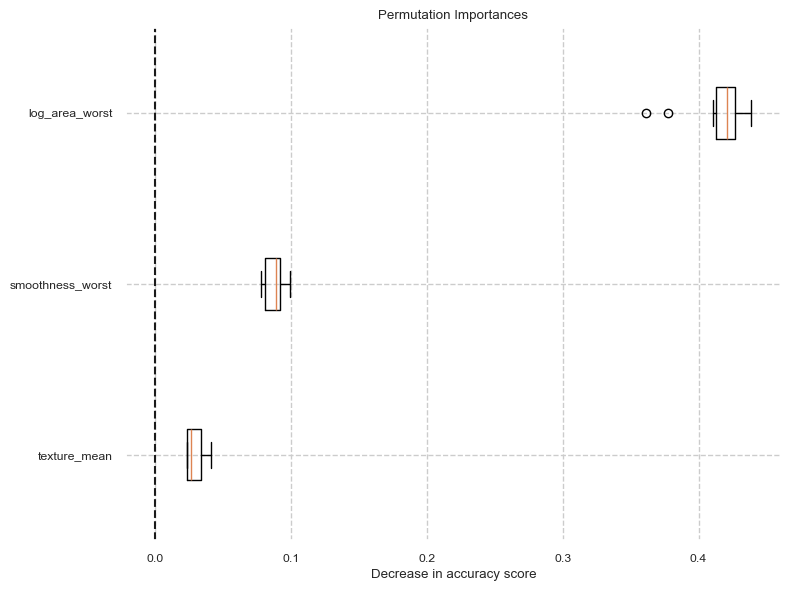

,features,importance,importance_std
1,log_area_worst,0.413,0.023
2,smoothness_worst,0.088,0.008
0,texture_mean,0.029,0.006


In [12]:
# calculate the permutation importance
lr_imp = permutation_importance(log_reg, X_train_proc, y_train_proc, n_repeats=10, random_state=5, n_jobs=-1)

# display the permutation importance results 
lr_imp_df = dp.display_permutation_importance(lr_imp, X_train_proc)
lr_imp_df

Observations
* `Log_area_worst` is the most important feature for the model to classify breast tumors. When values of the feature are permuted, the accuracy of the model decreases by 0.41, which corresponds to a significant drop in model accuracy.
* `Smoothness_worst` also contributes to the performance of the model, but to a lesser extent than `log_area_worst`. The decrease in accuracy when this feature is permuted is 0.088, which means that it still has some impact on the model, but is less critical.
* `Texture_mean` has the least importance of the three features. The reduction in accuracy when this feature is permuted is only 0.029. 

## 5 Decision Tree
### 5.1 Randomized Search

In [13]:
%%time
# define a preprocessing pipeline for decision tree models
dt_pipeline = ImbPipeline(steps=[
    ("imputer_adder", dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=False))),
    ("feature_selector", dp.FeatureSelector(selection_type="three_best")),
    ("smote", SMOTE(random_state=5)),
    ("classifier", DecisionTreeClassifier(random_state=5))
])

# define the parameters to test using cross validation. Hyperparameters were informed by Pedregosa et al. (2011) and GeeksforGeeks (2024a).
dt_param_grid = {
    "imputer_adder": [dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=False)),
                      dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=False))],
    "feature_selector": [dp.FeatureSelector(), dp.FeatureSelector(selection_type="three_best"),
                         dp.FeatureSelector(selection_type="worst")],
    "classifier__max_depth": range(1, 21),  # higher depth values are not chosen for interpretability reasons 
    "classifier__min_samples_split": range(2, 21),
    "classifier__min_samples_leaf": range(1, 21),
    "classifier__criterion": ['gini', 'entropy']
}

# train the decision tree model using cross validation
cv = StratifiedKFold(n_splits=5)

# initialize the random search 
random_search_dt = RandomizedSearchCV(estimator=dt_pipeline,
                                      param_distributions=dt_param_grid, n_iter=200,
                                      cv=cv, scoring=scoring, refit="f1", verbose=2, n_jobs=-1,
                                      random_state=5)

# conduct the search
random_search_dt.fit(X_train, y_train)

# show the parameters that yielded the best F1-score in the search
print(f"Best parameters (f1): {random_search_dt.best_params_}")
print(f"Best f1_score: {random_search_dt.best_score_}")

# extract the selected features
best_pipeline_dt = random_search_dt.best_estimator_
selected_features_dt = best_pipeline_dt.named_steps["feature_selector"].selected_features

# print information about the selected features
print(f"Number of selected features: {len(selected_features_dt)}")
print(f"Selected features: {selected_features_dt}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters (f1): {'imputer_adder': ImputerAdder(add_features=AddFeatures(add_interaction=False,
                                      deviation_features=['diff_area_perimeter_worst',
                                                          'diff_area_perimeter_mean',
                                                          'radius_worst_diff_mean',
                                                          'perimeter_worst_diff_mean',
                                                          'area_worst_diff_mean',
                                                          'radius_worst_ratio_mean',
                                                          'perimeter_worst_ratio_mean',
                                                          'area_worst_ratio_mean']),
             imputer=<class 'src.data_preparation.IQRCapper'>), 'feature_selector': FeatureSelector(selection_type='worst'), 'classifier__min_samples_s

Observations
* In the random search, there was no hyperparameter combination for the decision tree that achieved an F1-score of over 0.95 on average in the cross-validation.
* The best model achieves an F1-score of 0.94. It uses the ten `_worst` features for prediction and the `IQRCapper` method for outlier handling.
* The `RuntimeWarning` is most likely due to an invalid hyperparameter combination. Since it was possible to train at least 185 decision tree models, this warning is not considered severe. 

In [14]:
# display the results of the 20 best parameter combinations
results_dt = dp.format_random_search_results(random_search_dt)
results_dt.iloc[:20,:]

,mean_test_f1,rank_test_f1,param_imputer_adder,param_feature_selector,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
185,0.938,1,IQRCapper,FeatureSelector(selection_type='worst'),12,4,12,entropy,0.957,0.899,0.943,0.947,0.946,0.020,0.954,1,0.933,55,0.946,9
131,0.938,2,KNNReplacer,FeatureSelector(),5,5,9,entropy,0.971,0.899,0.943,0.919,0.959,0.026,0.954,2,0.928,57,0.950,7
174,0.934,3,IQRCapper,FeatureSelector(selection_type='three_best'),5,3,18,entropy,0.944,0.932,0.904,0.947,0.944,0.016,0.950,4,0.950,1,0.920,78
96,0.934,4,IQRCapper,FeatureSelector(selection_type='worst'),16,4,16,gini,0.958,0.899,0.958,0.919,0.935,0.023,0.950,9,0.939,16,0.931,37
104,0.933,5,IQRCapper,FeatureSelector(selection_type='worst'),14,4,16,gini,0.957,0.899,0.958,0.919,0.935,0.023,0.950,9,0.933,30,0.937,26
115,0.933,6,KNNReplacer,FeatureSelector(selection_type='three_best'),17,10,5,entropy,0.892,0.933,0.896,0.973,0.971,0.035,0.950,3,0.933,30,0.936,27
13,0.933,7,KNNReplacer,FeatureSelector(selection_type='worst'),7,3,13,entropy,0.971,0.899,0.919,0.930,0.946,0.025,0.950,8,0.928,70,0.940,16
160,0.932,8,KNNReplacer,FeatureSelector(selection_type='worst'),15,4,10,gini,0.958,0.899,0.958,0.909,0.935,0.024,0.948,19,0.944,5,0.923,62
107,0.932,9,KNNReplacer,FeatureSelector(selection_type='three_best'),4,2,11,entropy,0.919,0.917,0.930,0.935,0.958,0.015,0.948,14,0.944,5,0.921,72
43,0.932,10,KNNReplacer,FeatureSelector(selection_type='worst'),14,7,8,entropy,0.957,0.899,0.958,0.912,0.933,0.024,0.950,9,0.911,137,0.955,3


Observations
* The best 20 hyperparameter combinations all have an average F1-score of above 0.929, which is below the desired F1-score of 0.95.
* When dealing with outliers, there is no clear trend among the top 20 hyperparameter combinations. Although the `IQRCapper` method is among the top five models four times, the `KNNReplacer` was present in 12 of the top 20 hyperparameter combinations.
* The most common feature selection method among the 20 best hyperparameter combinations is the method where the 10 `_worst` features were selected (10 times). The second most common method (7 times) was the selection of the three best features (Mangasarian et al., 1995, p. 572) and the third most common (3 times) was CFS.
* For the hyperparameters `min_samples_split`, `min_samples_leaf` and `max_depth`, no clear tendency is recognizable.
* As a `criterion`, `entropy` occurs more frequently than `Gini` among the 20 best hyperparameter combinations.
* When looking at the F1-scores in the individual splits, it is noticeable that the F1-score varies greatly across the splits. This is also reflected in the consistently higher standard deviation (`std_test_f1`) in the decision trees than in the logistic regression models. This may indicate an excessive fit of the model to the data, i.e. overfitting (Kamath & Liu, 2021, pp. 86-87). 

In [15]:
# filter the search results to include only those entries where the F1-score for each split is greater than 0.95
high_f1_dt = dp.filter_for_high_f1(random_search_dt)
print(f"Number of parameter combinations with an F1-score of at least 0.95 for each split: {high_f1_dt.shape[0]}")
high_f1_dt

Number of parameter combinations with an F1-score of at least 0.95 for each split: 0


,mean_test_f1,rank_test_f1,param_imputer_adder,param_feature_selector,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision


Observations
* Since there is no model among the 20 best hyperparameter combinations that has an F1-score above 0.95 on average, there is also no model that has an F1-score above 0.95 for every split in the cross-validation.
* Nevertheless, in order to better compare the results with the logistic regression model, the most interpretable (and high-performing) hyperparameter combination is used to train the decision tree on the entire training set and the feature importance is calculated. 

### 5.2 Feature Importance

In [16]:
# select the rank of the most interpretable and high-performing model 
rank = 3

# retrieve the best hyperparameters based on the rank
params_dt = dp.get_parameters_by_rank(random_search_dt, rank)[0]

# display the results for the rank
print("Hyperparameters and results for the selected rank:")
display(results_dt[results_dt["rank_test_f1"] == rank])

# create a preprocessing pipeline with the best hyperparameters
preprocessing_dt = ImbPipeline(steps=[
    ("imputer_adder", params_dt["imputer_adder"]),
    ("feature_selector", params_dt["feature_selector"]),
    ("smote", SMOTE(random_state=5))
])

# fit the pipeline to the training set to preprocess it
X_train_proc_dt, y_train_proc_dt = preprocessing_dt.fit_resample(X_train, y_train)

# initialize a decision tree classifier with the best hyperparameters 
decision_tree = DecisionTreeClassifier(
    random_state=5,
    max_depth=params_dt["classifier__max_depth"],
    min_samples_split=params_dt["classifier__min_samples_split"],
    min_samples_leaf=params_dt["classifier__min_samples_leaf"],
    criterion=params_dt["classifier__criterion"]
)

# train the decision tree classifier
decision_tree.fit(X_train_proc_dt, y_train_proc_dt)

# define a preprocessing pipeline to apply the decision tree classifier to the unseen test data
preprocessing_dt_without_smote = ImbPipeline(steps=[
    ("imputer_adder", preprocessing_dt.named_steps["imputer_adder"]),
    ("feature_selector", preprocessing_dt.named_steps["feature_selector"])
])

# evaluate the trained model on the test data
print("Results of the model on the unseen test dataset:")
df_test_dt = dp.evaluate_model_on_test_data(preprocessing_dt_without_smote, X_test, y_test, decision_tree)
df_test_dt

Hyperparameters and results for the selected rank:


,mean_test_f1,rank_test_f1,param_imputer_adder,param_feature_selector,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_depth,param_classifier__criterion,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
174,0.934,3,IQRCapper,FeatureSelector(selection_type='three_best'),5,3,18,entropy,0.944,0.932,0.904,0.947,0.944,0.016,0.950,4,0.950,1,0.920,78


Results of the model on the unseen test dataset:


,Metric,Score
0,F1 Score,0.923
1,Accuracy,0.942
2,Recall,0.938
3,Precision,0.909


Observations
* The performance of the decision tree with the best hyperparameter combination is also insufficient on the test data. All scores are below 0.95.
* Although decision trees are easily interpretable (Molnar, 2019, p. 37), they do not achieve the required performance on the dataset used with the hyperparameter combinations and data preprocessing strategies tested. 

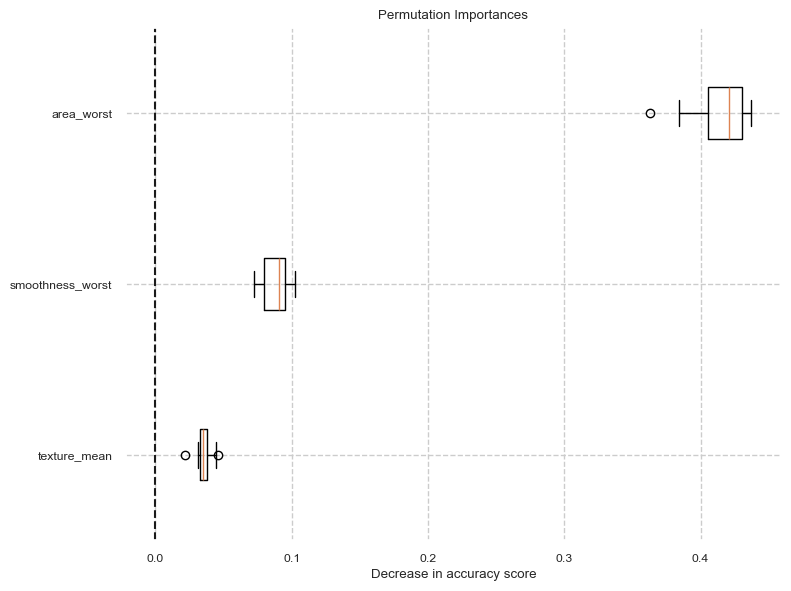

,features,importance,importance_std
1,area_worst,0.414,0.023
2,smoothness_worst,0.088,0.009
0,texture_mean,0.035,0.007


In [17]:
# calculate the permutation importance
dt_imp = permutation_importance(decision_tree, X_train_proc_dt, y_train_proc_dt, n_repeats=10, random_state=5, n_jobs=-1)

# display the permutation importance results 
dt_imp_df = dp.display_permutation_importance(dt_imp, X_train_proc_dt)
dt_imp_df

Observations
* The ranking of feature importances for the decision tree model looks very similar to the ranking of feature importances for the most interpretable logistic regression model. The order of the feature importances is the same and the exact values are also very similar. 
    * `Area_worst` is the most important feature for the model to classify breast tumors. When values of the feature are permuted, the accuracy of the model decreases by 0.414, which corresponds to a significant drop in model accuracy.
    * `Smoothness_worst` also contributes to the performance of the model, but to a lesser extent than `area_worst`. The decrease in accuracy when this feature is permuted is 0.088, which means that it still has some impact on the model, but is less critical.
    * `Texture_mean` has the least importance of the three features. The reduction in accuracy when this feature is permuted is only 0.035. 

## 6 Explainable Boosting Machine (EBM)
### 6.1 Randomized Search

In [18]:
%%time
# define a preprocessing pipeline for EBMs
ebm_pipeline = ImbPipeline(steps=[
    ("imputer_adder", dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=False))),
    ("log", dp.LogTransformer()),
    ("scaler", dp.Scaler()),
    ("feature_selector", dp.FeatureSelector(selection_type="three_best")),
    ("smote", SMOTE(random_state=5)),
    ("classifier", ExplainableBoostingClassifier(random_state=5))
])

# define the parameters to test using cross validation. Hyperparameters were informed by The InterpretML Contributors (2024).
ebm_param_grid = {
    "imputer_adder": [dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=False)),
                      dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=False))],
    "log": [None, dp.LogTransformer(transform_all=False), dp.LogTransformer(transform_all=True)],
    "scaler": [None, dp.Scaler(method="standard")],
    "feature_selector": [dp.FeatureSelector(), dp.FeatureSelector(selection_type="three_best"),
                         dp.FeatureSelector(selection_type="worst")],
    "classifier__max_bins": [1024, 4096, 16384],  
    "classifier__max_interaction_bins": [16, 32, 64],
    "classifier__interactions": [0, 0.5, 0.9],
    "classifier__greedy_ratio": [1, 1.5, 2],
    "classifier__cyclic_progress": [0, 0.5, 1],
    "classifier__learning_rate": [0.001, 0.01, 0.1]
}

# train the EBM using cross validation
cv = StratifiedKFold(n_splits=5)

# initialize the random search
random_search_ebm = RandomizedSearchCV(estimator=ebm_pipeline,
                                       param_distributions=ebm_param_grid, n_iter=200,
                                       cv=cv, scoring=scoring, refit="f1", verbose=2, n_jobs=-1,
                                       random_state=5)

# conduct the search
random_search_ebm.fit(X_train, y_train)

# show the parameters that yielded the best F1-score in the search
print(f"Best parameters (f1): {random_search_ebm.best_params_}")
print(f"Best f1_score: {random_search_ebm.best_score_}")

# extract the selected features
best_pipeline_ebm = random_search_ebm.best_estimator_
selected_features_ebm = best_pipeline_ebm.named_steps["feature_selector"].selected_features

# print information about the selected features
print(f"Number of selected features: {len(selected_features_ebm)}")
print(f"Selected features: {selected_features_ebm}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters (f1): {'scaler': Scaler(), 'log': LogTransformer(transform_all=True), 'imputer_adder': ImputerAdder(add_features=AddFeatures(add_interaction=False,
                                      deviation_features=['diff_area_perimeter_worst',
                                                          'diff_area_perimeter_mean',
                                                          'radius_worst_diff_mean',
                                                          'perimeter_worst_diff_mean',
                                                          'area_worst_diff_mean',
                                                          'radius_worst_ratio_mean',
                                                          'perimeter_worst_ratio_mean',
                                                          'area_worst_ratio_mean']),
             imputer=<class 'src.data_preparation.KNNReplacer'>), 'feature_selector': Fe

Observations
* There is at least one hyperparameter combination for the EBM, which achieves an F1-score of over 0.95 on average in the cross-validation.
* The best model uses a total of 10 log-transformed features to predict whether tumors are malignant or benign.
* The features for the best model where selected based on the CFS method.
* The search for the best hyperparameter combination in the defined parameter space took significantly longer for the EBM than for the logistic regression models and the decision trees, as the EBM is considerably more complex than the other two model types (Kamath & Liu, 2021, p. 129).

In [19]:
# display the results of the 20 best parameter combinations
results_ebm = dp.format_random_search_results(random_search_ebm)
results_ebm.iloc[:20,:]

,mean_test_f1,rank_test_f1,param_scaler,param_log,param_imputer_adder,param_feature_selector,param_classifier__max_interaction_bins,param_classifier__max_bins,param_classifier__learning_rate,param_classifier__interactions,param_classifier__greedy_ratio,param_classifier__cyclic_progress,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
45,0.977,1,Scaler(),LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),32,1024,0.001,0.000,1.000,1.000,0.971,0.958,0.957,1.000,1.000,0.019,0.984,1,0.961,3,0.994,3
25,0.972,2,None,LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),64,16384,0.010,0.900,1.500,0.000,0.971,0.958,0.957,0.986,0.986,0.013,0.979,4,0.956,30,0.989,11
18,0.971,3,Scaler(),LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),32,16384,0.010,0.000,1.500,0.000,0.957,0.958,0.957,1.000,0.986,0.018,0.979,2,0.956,30,0.989,11
66,0.971,4,Scaler(),LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),64,4096,0.001,0.900,2.000,0.000,0.957,0.971,0.957,0.986,0.986,0.013,0.979,4,0.950,99,0.995,1
192,0.971,4,None,LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),16,4096,0.001,0.900,1.500,0.000,0.957,0.971,0.957,0.986,0.986,0.013,0.979,4,0.950,99,0.995,1
16,0.971,6,None,LogTransformer(),KNNReplacer,FeatureSelector(),64,4096,0.010,0.000,1.000,0.500,0.971,0.958,0.941,1.000,0.986,0.021,0.979,2,0.956,30,0.989,11
191,0.969,7,Scaler(),LogTransformer(),KNNReplacer,FeatureSelector(),64,1024,0.100,0.500,1.500,1.000,0.986,0.944,0.957,0.971,0.986,0.016,0.977,14,0.956,30,0.983,28
189,0.969,7,None,LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),64,1024,0.001,0.500,1.000,0.000,0.971,0.944,0.957,0.986,0.986,0.016,0.977,7,0.956,30,0.983,28
183,0.969,9,None,LogTransformer(),IQRCapper,FeatureSelector(),64,4096,0.001,0.000,1.500,1.000,0.971,0.958,0.957,0.972,0.986,0.011,0.977,16,0.956,30,0.983,32
179,0.969,10,None,LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),64,1024,0.100,0.900,1.000,1.000,0.971,0.958,0.957,0.986,0.972,0.011,0.977,14,0.950,99,0.989,18


Observations
* The best 20 hyperparameter combinations all have an average F1-score above 0.95.
* Although the best hyperparameter combination includes a standardization of the features, no scaling of the features was used in 11 of the 20 best hyperparameter combinations.
* In contrast to the other two model types, the `KNNReplacer` method for outlier treatment performs better here than the `IQRCapper` method.
* The situation is similar for the feature selection method: all 20 best hyperparameter combinations include the CFS method and neither of the other two methods.
* For the parameter `max_interaction_bins`, higher interaction bins (32 and 64) yield better results than lower interaction bins (16).
* No clear tendencies can be recognized for the parameters `max_bins`, `interactions`, `greedy_ratio` and `cyclic_progress`. Accordingly, these parameters appear to be less decisive for the performance of the model than the other parameters.  
* A smaller learning rate (0.001, 0.01) leads to better results than a larger learning rate (0.1).
* The standard deviation of the F1-scores of the hyperparameter combinations is similarly low as for the logistic regression models.  
* The average accuracy of the best 20 hyperparameter combinations is consistently above 0.975, the average recall is consistently above 0.944 and the average precision is at least 0.978. Accordingly, the EBMs on the breast cancer dataset show consistently good results.

In [20]:
# filter the search results to include only those entries where the F1-score for each split is greater than 0.95
high_f1_ebm = dp.filter_for_high_f1(random_search_ebm)
print(f"Number of parameter combinations with an F1-score of at least 0.95 for each split: {high_f1_ebm.shape[0]}")
high_f1_ebm

Number of parameter combinations with an F1-score of at least 0.95 for each split: 23


,mean_test_f1,rank_test_f1,param_scaler,param_log,param_imputer_adder,param_feature_selector,param_classifier__max_interaction_bins,param_classifier__max_bins,param_classifier__learning_rate,param_classifier__interactions,param_classifier__greedy_ratio,param_classifier__cyclic_progress,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
45,0.977,1,Scaler(),LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),32,1024,0.001,0.000,1.000,1.000,0.971,0.958,0.957,1.000,1.000,0.019,0.984,1,0.961,3,0.994,3
25,0.972,2,None,LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),64,16384,0.010,0.900,1.500,0.000,0.971,0.958,0.957,0.986,0.986,0.013,0.979,4,0.956,30,0.989,11
18,0.971,3,Scaler(),LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),32,16384,0.010,0.000,1.500,0.000,0.957,0.958,0.957,1.000,0.986,0.018,0.979,2,0.956,30,0.989,11
66,0.971,4,Scaler(),LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),64,4096,0.001,0.900,2.000,0.000,0.957,0.971,0.957,0.986,0.986,0.013,0.979,4,0.950,99,0.995,1
192,0.971,4,None,LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),16,4096,0.001,0.900,1.500,0.000,0.957,0.971,0.957,0.986,0.986,0.013,0.979,4,0.950,99,0.995,1
183,0.969,9,None,LogTransformer(),IQRCapper,FeatureSelector(),64,4096,0.001,0.000,1.500,1.000,0.971,0.958,0.957,0.972,0.986,0.011,0.977,16,0.956,30,0.983,32
179,0.969,10,None,LogTransformer(transform_all=True),IQRCapper,FeatureSelector(),64,1024,0.100,0.900,1.000,1.000,0.971,0.958,0.957,0.986,0.972,0.011,0.977,14,0.950,99,0.989,18
33,0.969,13,None,LogTransformer(transform_all=True),KNNReplacer,FeatureSelector(),16,1024,0.001,0.500,1.500,0.000,0.957,0.958,0.957,0.986,0.986,0.014,0.977,7,0.950,99,0.989,11
39,0.966,20,Scaler(),None,KNNReplacer,FeatureSelector(),64,4096,0.001,0.500,1.000,0.500,0.971,0.971,0.957,0.971,0.959,0.007,0.975,27,0.944,153,0.989,7
163,0.966,23,Scaler(),None,KNNReplacer,FeatureSelector(),64,4096,0.001,0.000,2.000,1.000,0.971,0.957,0.957,0.972,0.972,0.008,0.975,24,0.944,153,0.989,8


Observations
* For the EBM, there are a total of 23 hyperparameter combinations that achieved an F1-score of at least 0.95 in each split within the cross-validation.
* To evaluate the feature importance in the EBM, the model that is best interpretable based on the selected hyperparameters and preprocessing is identified: The model ranked 29 (`rank_test_f1`) is considered the best interpretable model for the following reasons:
   * It uses only three features (plus interactions) for prediction. This is much easier for people to understand than a model that bases its predictions on considerably more features (Molnar, 2019, p. 29). For the other hyperparameter combinations, significantly more features are used for prediction. 
   * Not all of the three features are log-transformed. Non-transformed features are easier to interpret than transformed features (Molnar, 2019, p. 27).
   * The model does not use a scaling method, so the features are in their original units and may be more easily understood than scaled features by non-technical personnel. 

### 6.2 Feature Importance

In [21]:
# select the rank of the most interpretable model based on the hyperparameters with a sufficiently high f1-score 
rank = 29  

# retrieve the best hyperparameters based on the rank
params_ebm = dp.get_parameters_by_rank(random_search_ebm, rank)[0]

# display the results for the rank
print("Hyperparameters and results for the selected rank:")
display(results_ebm[results_ebm["rank_test_f1"] == rank])

# create a preprocessing pipeline with the best hyperparameters
preprocessing_ebm = ImbPipeline(steps=[
    ("imputer_adder", params_ebm["imputer_adder"]),
    ("log", params_ebm["log"]),
    ("scaler", params_ebm["scaler"]),
    ("feature_selector", params_ebm["feature_selector"]),
    ("smote", SMOTE(random_state=5))
])

# fit the pipeline to the training set to preprocess it
X_train_proc_ebm, y_train_proc_ebm = preprocessing_ebm.fit_resample(X_train, y_train)

# initialize an EBM with the best hyperparameters 
ebm = ExplainableBoostingClassifier(
    random_state=5,
    max_bins=params_ebm["classifier__max_bins"],
    max_interaction_bins=params_ebm["classifier__max_interaction_bins"],
    interactions=params_ebm["classifier__interactions"],
    greedy_ratio=params_ebm["classifier__greedy_ratio"],
    cyclic_progress=params_ebm["classifier__cyclic_progress"],
    learning_rate=params_ebm["classifier__learning_rate"]
)

# train the EBM
ebm.fit(X_train_proc_ebm, y_train_proc_ebm)

# define a preprocessing pipeline to apply the EBM to the unseen test data
preprocessing_ebm_without_smote = ImbPipeline(steps=[
    ("imputer_adder", preprocessing_ebm.named_steps["imputer_adder"]),
    ("log", preprocessing_ebm.named_steps["log"]),
    ("scaler", preprocessing_ebm.named_steps["scaler"]),
    ("feature_selector", preprocessing_ebm.named_steps["feature_selector"])
])

# evaluate the trained model on the test data
print("Results of the model on the unseen test dataset:")
df_test_ebm = dp.evaluate_model_on_test_data(preprocessing_ebm_without_smote, X_test, y_test, ebm)
df_test_ebm

Hyperparameters and results for the selected rank:


,mean_test_f1,rank_test_f1,param_scaler,param_log,param_imputer_adder,param_feature_selector,param_classifier__max_interaction_bins,param_classifier__max_bins,param_classifier__learning_rate,param_classifier__interactions,param_classifier__greedy_ratio,param_classifier__cyclic_progress,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
120,0.964,29,None,LogTransformer(),IQRCapper,FeatureSelector(selection_type='three_best'),16,16384,0.100,0.500,1.000,0.000,0.958,0.960,0.957,0.973,0.972,0.007,0.973,32,0.967,1,0.963,61


Results of the model on the unseen test dataset:


,Metric,Score
0,F1 Score,0.969
1,Accuracy,0.977
2,Recall,0.969
3,Precision,0.969


Observations
* The performance of the most interpretable EBM on the test set is consistently very good: The F1-score, recall and precision are at 0.969, while the accuracy is at 0.977. Thus, the F1-score is above the desired value of 0.95.
* Accordingly, the selected EBM meets the requirements in terms of performance and interpretability. 

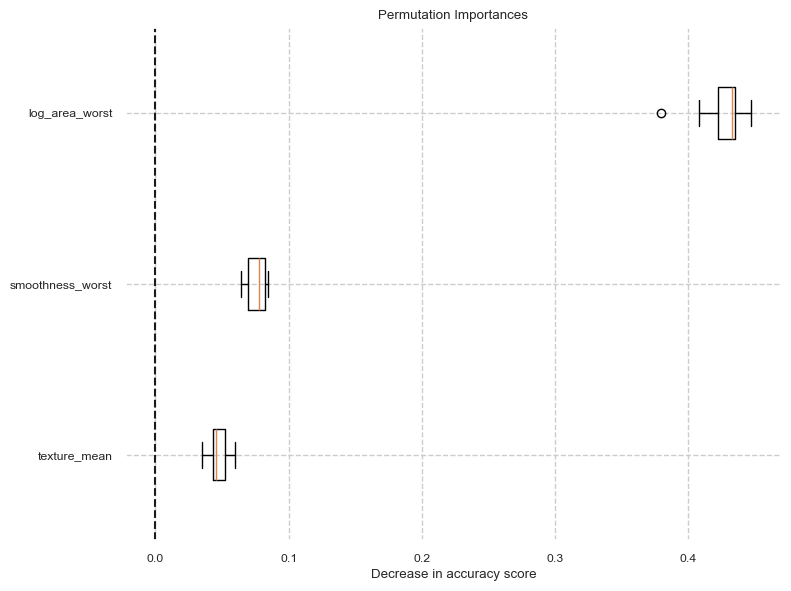

,features,importance,importance_std
1,log_area_worst,0.426,0.019
2,smoothness_worst,0.076,0.007
0,texture_mean,0.047,0.008


In [22]:
# calculate the permutation importance
ebm_imp = permutation_importance(ebm, X_train_proc_ebm, y_train_proc_ebm, n_repeats=10, random_state=5, n_jobs=-1)

# display the permutation importance results
ebm_imp_df = dp.display_permutation_importance(ebm_imp, X_train_proc_ebm)
ebm_imp_df

Observations
* The ranking of feature importances for the most interpretable EBM looks very similar to the ranking of feature importances for the most interpretable logistic regression model and decision tree model. The order of the feature importances is the same and the exact values are also very similar. 
    * `Log_area_worst` is the most important feature for the model to classify breast tumors. When values of the feature are permuted, the accuracy of the model decreases by 0.426, which corresponds to a significant drop in model accuracy.
    * `Smoothness_worst` also contributes to the performance of the model, but to a lesser extent than `log_area_worst`. The decrease in accuracy when this feature is permuted is 0.076, which means that it still has some impact on the model, but is less critical.
    * `Texture_mean` has the least importance of the three features. The reduction in accuracy when this feature is permuted is only 0.047. 

## 7 Random Forest
### 7.1 Randomized Search

In [23]:
%%time
# define a preprocessing pipeline for random forests
rf_pipeline = ImbPipeline(steps=[
    ("imputer_adder", dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=False))),
    ("feature_selector", dp.FeatureSelector(selection_type="three_best")),
    ("smote", SMOTE(random_state=5)),
    ("classifier", RandomForestClassifier(random_state=5))
])

# define the parameters to test using cross validation. Hyperparameters were informed by Koehrsen (2018)
rf_param_grid = {
    "imputer_adder": [dp.ImputerAdder(imputer=dp.IQRCapper, add_features=dp.AddFeatures(add_interaction=False)), 
                      dp.ImputerAdder(imputer=dp.KNNReplacer, add_features=dp.AddFeatures(add_interaction=False))],
    "feature_selector": [dp.FeatureSelector(), dp.FeatureSelector(selection_type="three_best"),
                         dp.FeatureSelector(selection_type="worst")],
    "classifier__n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],  
    "classifier__max_depth": [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__bootstrap": [True, False],
    "classifier__criterion": ['gini', 'entropy']
}

# train the random forest using cross validation
cv = StratifiedKFold(n_splits=5)

# initialize the random search
random_search_rf = RandomizedSearchCV(estimator=rf_pipeline,
                                      param_distributions=rf_param_grid, n_iter=200,
                                      cv=cv, scoring=scoring, refit="f1", verbose=1, n_jobs=-1,
                                      random_state=5)

# conduct the search
random_search_rf.fit(X_train, y_train)

# show the parameters that yielded the best F1-score in the search
print(f"Best parameters (f1): {random_search_rf.best_params_}")
print(f"Best f1_score: {random_search_rf.best_score_}")

# extract the selected features
best_pipeline_rf = random_search_rf.best_estimator_
selected_features_rf = best_pipeline_rf.named_steps["feature_selector"].selected_features

# print information about the selected features
print(f"Number of selected features: {len(selected_features_rf)}")
print(f"Selected features: {selected_features_rf}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters (f1): {'imputer_adder': ImputerAdder(add_features=AddFeatures(add_interaction=False,
                                      deviation_features=['diff_area_perimeter_worst',
                                                          'diff_area_perimeter_mean',
                                                          'radius_worst_diff_mean',
                                                          'perimeter_worst_diff_mean',
                                                          'area_worst_diff_mean',
                                                          'radius_worst_ratio_mean',
                                                          'perimeter_worst_ratio_mean',
                                                          'area_worst_ratio_mean']),
             imputer=<class 'src.data_preparation.KNNReplacer'>), 'feature_selector': FeatureSelector(), 'classifier__n_estimators': 200, 'classifier__

Observations
* There is at least one hyperparameter combination for the random forest model, which achieves an F1-score of over 0.95 on average in the cross-validation.
* The best model uses a total of 11 features to predict whether tumors are malignant or benign.
* As for the best EBM, the features for the best model where selected based on the CFS method.
* The search for the best hyperparameter combination in the defined parameter space was significantly faster for the random forest models than for the EBMs.

In [24]:
# display the results of the 20 best parameter combinations
results_rf = dp.format_random_search_results(random_search_rf)
results_rf.iloc[:20,:]

,mean_test_f1,rank_test_f1,param_imputer_adder,param_feature_selector,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__criterion,param_classifier__bootstrap,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
194,0.963,1,KNNReplacer,FeatureSelector(),1600,2,1,sqrt,40,gini,False,0.958,0.943,0.971,0.973,0.972,0.012,0.973,1,0.956,2,0.972,1
149,0.963,1,KNNReplacer,FeatureSelector(),200,2,1,log2,10,gini,False,0.958,0.943,0.971,0.973,0.972,0.012,0.973,1,0.956,2,0.972,1
110,0.961,3,KNNReplacer,FeatureSelector(),2000,2,1,log2,60,entropy,False,0.958,0.943,0.958,0.973,0.972,0.011,0.971,3,0.956,2,0.967,18
39,0.961,3,KNNReplacer,FeatureSelector(),1800,5,1,log2,90,entropy,False,0.958,0.943,0.958,0.973,0.972,0.011,0.971,3,0.956,2,0.967,18
67,0.961,5,KNNReplacer,FeatureSelector(),400,2,1,sqrt,80,gini,False,0.958,0.943,0.971,0.959,0.972,0.011,0.971,5,0.950,62,0.972,3
188,0.959,6,IQRCapper,FeatureSelector(selection_type='three_best'),600,2,1,log2,40,entropy,False,0.958,0.946,0.944,0.973,0.973,0.012,0.969,7,0.972,1,0.946,98
6,0.958,7,IQRCapper,FeatureSelector(selection_type='worst'),1000,2,1,log2,90,entropy,True,0.971,0.943,0.958,0.947,0.972,0.012,0.969,28,0.956,2,0.963,23
177,0.958,8,KNNReplacer,FeatureSelector(),2000,2,2,log2,100,gini,False,0.932,0.943,0.958,0.973,0.986,0.020,0.969,6,0.956,2,0.962,31
62,0.958,9,KNNReplacer,FeatureSelector(),1000,2,2,log2,100,gini,False,0.932,0.943,0.971,0.973,0.972,0.018,0.969,7,0.956,2,0.962,30
133,0.958,10,IQRCapper,FeatureSelector(selection_type='worst'),200,2,2,sqrt,10,entropy,True,0.971,0.930,0.958,0.960,0.972,0.015,0.969,16,0.956,2,0.962,26


Observations
* The best 20 hyperparameter combinations all have an average F1-score above 0.95.
* As with the EBMs, the `KNNReplacer` method for outlier handling performs better than the `IQRCapper` method.
* The CFS method delivers the best results, followed by the selection of the 10 `_worst` features. The feature selection of the three best features is only represented once among the 20 best hyperparameter combinations.
* No clear tendencies can be identified for the parameters `n_estimators` and `criterion`. Accordingly, these parameters seem to be less decisive for the performance of the model than the other parameters.
* Random forest models that require at least 2 samples for a split (`min_samples_split`) achieve better performance on average than models that require more samples for a split.
* Random forest models that require at least 1 sample for a leaf (`min_samples_leaf`) perform better on average than models that require more samples for a leaf.
* Limiting the number of features considered in each split (`max_depth` = `log2` or `sqrt`) works better than not limiting the number of features for this purpose.
* Limiting the maximum depth of each estimator (`max_depth`) also leads to better results than no limit, even if there is no clear tendency regarding the exact maximum depth.
* Models that do not use bootstrapping perform better on average among the 20 best hyperparameter combinations than models that use bootstrapping.   
* The standard deviation of the F1-scores of the hyperparameter combinations is similarly low as for the logistic regression models and the EBMs.
* The average precision of the best 20 hyperparameter combinations is consistently above 0.969, the average recall is consistently above 0.950 and the average precision is at least 0.946. Accordingly, the random forest models for the breast cancer dataset show consistently good results.

In [25]:
# filter the search results to include only those entries where the F1-score for each split is greater than 0.95
high_f1_rf = dp.filter_for_high_f1(random_search_rf)
print(f"Number of parameter combinations with an F1-score of at least 0.95 for each split: {high_f1_rf.shape[0]}")
high_f1_rf

Number of parameter combinations with an F1-score of at least 0.95 for each split: 0


,mean_test_f1,rank_test_f1,param_imputer_adder,param_feature_selector,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__criterion,param_classifier__bootstrap,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision


Observations
* Although the average F1-score for the 20 best hyperparameter combinations is above 0.95, no combination could be identified among the 200 parameter combinations tested for which the F1-score was above 0.95 in all splits of the cross-validation.
* Therefore, the random forest models, like the decision trees, do not fulfill the performance criterion and will therefore not be finally selected. 
* To better compare the results with the other three models, the hyperparameter combination that selects the three best features is used to train the random forest model on the entire training set, and the feature importance is calculated. 

### 7.2 Feature Importance

In [26]:
# select the rank of the most interpretable and high-performing model 
rank = 6 

# retrieve the best hyperparameters based on the rank
params_rf = dp.get_parameters_by_rank(random_search_rf, rank)[0]

# display the results for the rank
print("Hyperparameters and results for the selected rank:")
display(results_rf[results_rf["rank_test_f1"] == rank])

# create a preprocessing pipeline with the best hyperparameters
preprocessing_rf = ImbPipeline(steps=[
    ("imputer_adder", params_rf["imputer_adder"]),
    ("feature_selector", params_rf["feature_selector"]),
    ("smote", SMOTE(random_state=5))
])

# fit the pipeline to the training set to preprocess it
X_train_proc_rf, y_train_proc_rf = preprocessing_rf.fit_resample(X_train, y_train)

# initialize a random forest classifier with the best hyperparameters 
rf = RandomForestClassifier(
    random_state=5,
    n_estimators=params_rf["classifier__n_estimators"],
    max_depth=params_rf["classifier__max_depth"],
    min_samples_split=params_rf["classifier__min_samples_split"],
    min_samples_leaf=params_rf["classifier__min_samples_leaf"],
    max_features=params_rf["classifier__max_features"],
    bootstrap=params_rf["classifier__bootstrap"],
    criterion=params_rf["classifier__criterion"]
)

# train the random forest classifier
rf.fit(X_train_proc_rf, y_train_proc_rf)

# define a preprocessing pipeline to apply the random forest classifier to the unseen test data
preprocessing_rf_without_smote = ImbPipeline(steps=[
    ("imputer_adder", preprocessing_rf.named_steps["imputer_adder"]),
    ("feature_selector", preprocessing_rf.named_steps["feature_selector"])
])

# evaluate the trained model on the test data
print("Results of the model on the unseen test dataset:")
df_test_rf = dp.evaluate_model_on_test_data(preprocessing_rf_without_smote, X_test, y_test, rf)
df_test_rf

Hyperparameters and results for the selected rank:


,mean_test_f1,rank_test_f1,param_imputer_adder,param_feature_selector,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__min_samples_leaf,param_classifier__max_features,param_classifier__max_depth,param_classifier__criterion,param_classifier__bootstrap,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,std_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_recall,rank_test_recall,mean_test_precision,rank_test_precision
188,0.959,6,IQRCapper,FeatureSelector(selection_type='three_best'),600,2,1,log2,40,entropy,False,0.958,0.946,0.944,0.973,0.973,0.012,0.969,7,0.972,1,0.946,98


Results of the model on the unseen test dataset:


,Metric,Score
0,F1 Score,0.955
1,Accuracy,0.965
2,Recall,1.000
3,Precision,0.914


Observations
* The performance of the random forest on the test set based on the four scores is mixed: The recall is perfect, which means that all malignant tumors could be correctly identified as such. However, the precision is significantly lower at 0.914. This means that not all tumors classified as malignant were actually malignant. The accuracy and the F1-score show good values above 0.95.
* It is noteworthy that the random forest performs better on the test set than on the individual splits in the cross-validation during hyperparameter selection. This suggests that the performance of the random forest model may be more dependent on the selected data than the performance of the logistic regression models and the EBMs.

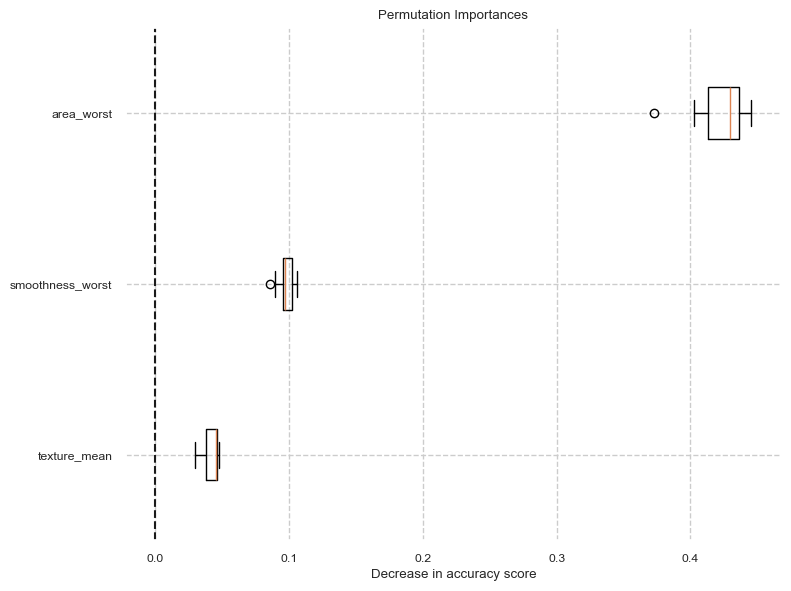

,features,importance,importance_std
1,area_worst,0.422,0.021
2,smoothness_worst,0.097,0.006
0,texture_mean,0.042,0.006


In [27]:
# calculate the permutation importance
rf_imp = permutation_importance(rf, X_train_proc_rf, y_train_proc_rf, n_repeats=10, random_state=5, n_jobs=-1)

# display the permutation importance results 
rf_imp_df = dp.display_permutation_importance(rf_imp, X_train_proc_rf)
rf_imp_df

Observations
* The ranking of feature importances for the random forest model looks very similar to the ranking of feature importances for the most interpretable logistic regression model, decision tree model, and EBM. The order of the feature importances is the same and the exact values are also very similar. 
    * `Area_worst` is the most important feature for the model to classify breast tumors. When values of the feature are permuted, the accuracy of the model decreases by 0.422, which corresponds to a significant drop in model accuracy.
    * `Smoothness_worst` also contributes to the performance of the model, but to a lesser extent than `area_worst`. The decrease in accuracy when this feature is permuted is 0.097, which means that it still has some impact on the model, but is less critical.
    * `Texture_mean` has the least importance of the three features. The reduction in accuracy when this feature is permuted is only 0.042. 

## III. References

GeeksforGeeks. (2024a, April 16). _How to tune a decision tree in hyperparameter tuning._ https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/

GeeksforGeeks. (2024b, May 22). _How to optimize logistic regression performance._ https://www.geeksforgeeks.org/how-to-optimize-logistic-regression-performance/

The InterpretML Contributors. (2024, September 28). _Hyperparameters._ https://interpret.ml/docs/hyperparameters.html

Kamath, U., & Liu, J. (2021). _Explainable artificial intelligence: An introduction to interpretable machine learning_ (1st ed.). Springer. https://doi.org/10.1007/978-3-030-83356-5

Koehrsen, W. (2018, January 10). _Hyperparameter tuning the random forest in Python._ Towards Data Science. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Mangasarian, O. L., Street, W. N., & Wolberg, W. H. (1995). Breast cancer diagnosis and prognosis via linear programming. _Operations Research_, 43(4), 570–577. https://doi.org/10.1287/opre.43.4.570

Molnar, C. (2019). Interpretable machine learning: A guide for making black box models explainable. Leanpub. http://leanpub.com/interpretable-machine-learning 

Naik, K. (2021). _P2: Logistic Regression - hyperparameter tuning._ https://www.kaggle.com/code/funxexcel/p2-logistic-regression-hyperparameter-tuning

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. _Journal of Machine Learning Research_, 12(85), 2825–2830. https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html
